## 1. Environment Setup

In [1]:
%pip install keras matplotlib datasets fiftyone keras-unet flask_cors pyngrok

Defaulting to user installation because normal site-packages is not writeable
  Using cached fiftyone-1.4.1-py3-none-any.whl.metadata (23 kB)
  Using cached fiftyone_brain-0.20.1-py3-none-any.whl.metadata (4.8 kB)
  Using cached fiftyone_db-1.1.7.tar.gz (7.9 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Using cached fiftyone-1.4.1-py3-none-any.whl (10.8 MB)
Using cached fiftyone_brain-0.20.1-py3-none-any.whl (110 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 11.5 MB/s eta 0:00:00m eta 0:00:010:00:01
  Created wheel for fiftyone-db: filename=fiftyone_db-1.1.7-py3-none-manylinux1_x86_64.whl size=50838734 sha256=ba84b869e3389778b4721ae9862938624126c4f6dd365be9a6aa6d52eebcb9d4
  Stored in directory: /home/hubertas/.cache/pip/wheels/0c/47/36/202afea40fd3e84303b1d340359c9a35ded3bac597d9f36806
Successfully built fiftyone-db
  Attempting uninstall: fsspec
    Found existing installation:

In [2]:
import os, glob, random, zipfile, tensorflow as tf, numpy as np
import matplotlib.pyplot as plt, matplotlib.patches as mpatches
from tensorflow.keras import layers, models
from tensorflow import keras
from tensorflow.keras.applications import MobileNetV2
from keras_unet.models import custom_unet
from tensorflow.keras.layers import (
    Input, Conv2D, DepthwiseConv2D, BatchNormalization,
    ReLU, GlobalAveragePooling2D, Dense, Add, Activation,
    ZeroPadding2D, Reshape, Dropout, Concatenate, UpSampling2D
)
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, Callback, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.mixed_precision import set_global_policy
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    accuracy_score,
    f1_score,
)
from datasets import load_dataset
import tensorflow_datasets as tfds
import fiftyone as fo
import fiftyone.zoo as foz
from fiftyone import ViewField as F

from flask import Flask, request, send_file, jsonify
from flask_cors import CORS
from io import BytesIO
from PIL import Image
import requests
from pyngrok import ngrok

2025-04-29 22:05:24.110409: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-29 22:05:24.356971: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-29 22:05:25.717876: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


### Dataset Download and init

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
TRAIN_MODE     = False
# MODEL_PATH     = "/content/drive/MyDrive/colab_content/unet_model.keras"
MODEL_PATH     = "./unet_model.keras"
TARGET_CLASSES = ["airplane", "train", "boat"]
CLASS_NAMES    = {0: "bg", 1: "airplane", 2: "train", 3: "boat"}
IMG_SIZE       = (224,224)
BATCH_SIZE     = 16
AUTOTUNE       = tf.data.AUTOTUNE
NUM_CLASSES    = len(TARGET_CLASSES) + 1
EPOCHS         = 10
SAMPLE_COUNT   = 3000
NGROK_AUTH_TOKEN = "2v8l4mW8zOFneFzX7p47qORuEwS_4EcRU64N6iq1mUNEpXN3G"

In [ ]:
if True:
    full = foz.load_zoo_dataset(
        "coco-2017",
        split       = "train",
        label_types = ["segmentations"],
        classes     = TARGET_CLASSES,
        shuffle     = True,
        max_samples = SAMPLE_COUNT,
    )

ids = full.values("id")
random.shuffle(ids)
n = len(ids)
train_ids = ids[: int(0.7 * n)]
val_ids   = ids[int(0.7 * n): int(0.85 * n)]
test_ids  = ids[int(0.85 * n):]

train_fo = full.select(train_ids)
val_fo   = full.select(val_ids)
test_fo  = full.select(test_ids)

print(f"loaded {train_fo.count()} train and {val_fo.count()} val samples")

loaded 2100 train and 450 val samples


In [ ]:
def gen_from_fo(fo_ds):
    for sample in fo_ds:
        img = tf.io.decode_jpeg(tf.io.read_file(sample.filepath), channels=3)
        H, W = img.shape[:2]

        sem   = np.zeros((H, W), np.int32)
        wrote = False

        for det in sample.ground_truth.detections:
            lbl = det.label.lower()
            if lbl not in TARGET_CLASSES:
                continue
            m = np.array(det.mask)
            if not m.any():
                continue

            x_rel, y_rel, w_rel, h_rel = det.bounding_box
            x0 = int(x_rel * W)
            y0 = int(y_rel * H)

            mh, mw = m.shape
            x1 = min(x0 + mw, W)
            y1 = min(y0 + mh, H)

            m = m[: y1 - y0, : x1 - x0]
            if m.size == 0:
                continue

            cls_idx = TARGET_CLASSES.index(lbl) + 1
            sem[y0:y1, x0:x1][m] = cls_idx
            wrote = True

        if not wrote:
            continue

        img = tf.image.resize(img, IMG_SIZE) / 255.0
        sem = tf.image.resize(
            tf.expand_dims(sem, -1), IMG_SIZE, method="nearest"
        )[..., 0]

        yield img, tf.cast(sem, tf.int32)


def optimize_dataset(ds, batch_size, cache=True):
    if cache:
        ds = ds.cache()

    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)

    return ds


output_sig = (
    tf.TensorSpec((*IMG_SIZE, 3), tf.float32),
    tf.TensorSpec(IMG_SIZE, tf.int32),
)

train_ds = tf.data.Dataset.from_generator(
    lambda: gen_from_fo(train_fo), output_signature=output_sig
).cache().shuffle(500).repeat().batch(BATCH_SIZE).prefetch(AUTOTUNE)

val_ds = tf.data.Dataset.from_generator(
    lambda: gen_from_fo(val_fo), output_signature=output_sig
).batch(BATCH_SIZE).prefetch(AUTOTUNE)

test_ds = tf.data.Dataset.from_generator(
    lambda: gen_from_fo(test_fo), output_signature=output_sig
).batch(BATCH_SIZE).prefetch(AUTOTUNE)


def fix_dataset_shape(ds):
    def ensure_shape(images, masks):
        if len(images.shape) > 4:
            images = tf.squeeze(images, axis=0)

        if len(masks.shape) > 3:
            masks = tf.squeeze(masks, axis=0)

        return images, masks

    return ds.map(ensure_shape, num_parallel_calls=AUTOTUNE)

train_ds = fix_dataset_shape(train_ds)
val_ds = fix_dataset_shape(val_ds)
test_ds = fix_dataset_shape(test_ds)

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

# Preparation for model training

In [9]:
def compute_class_weights(dataset):
    """
    Class weights based on class frequency.
    """
    # Count the pixels per class
    class_counts = np.zeros(NUM_CLASSES)
    sample_count = 0

    for _, masks in dataset.unbatch().take(500):
        masks_np = masks.numpy().flatten()
        for i in range(NUM_CLASSES):
            class_counts[i] += np.sum(masks_np == i)
        sample_count += masks_np.size

    class_weights = sample_count / (class_counts * NUM_CLASSES + 1e-5)

    # Normalize weights
    class_weights = class_weights / np.sum(class_weights) * NUM_CLASSES

    return dict(enumerate(class_weights))

def weighted_sparse_categorical_crossentropy(class_weights):
    """
    Weighted sparse categorical crossentropy loss function.
    """
    def loss(y_true, y_pred):
        # Standard sparse categorical crossentropy
        losses = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)

        # Apply class weights
        weights = tf.gather(tf.constant(list(class_weights.values()), dtype=tf.float32),
                           tf.cast(y_true, tf.int32))

        return tf.reduce_mean(losses * weights)

    return loss

# Calculate class weights from training data
# class_weights = compute_class_weights(train_ds)
# print("Class weights:", class_weights)

# Model architecture creation

In [ ]:
set_global_policy('mixed_float16')
def conv_block(inputs, filters, kernel_size=3, activation='relu', padding='same'):
    x = Conv2D(filters, kernel_size, padding=padding)(inputs)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)

    x = Conv2D(filters, kernel_size-1 if kernel_size > 1 else 1, padding=padding)(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)

    return x

def build_unet(input_shape=(224, 224, 3), num_classes=4):
    # Input
    inputs = Input(input_shape)

    # Encoder
    # Level 1
    conv1 = conv_block(inputs, 32)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    # Level 2
    conv2 = conv_block(pool1, 64)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Level 3
    conv3 = conv_block(pool2, 128)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    # Level 4
    # Bridge
    bridge = conv_block(pool3, 256)

    # Decoder
    # Level 3
    up3 = UpSampling2D(size=(2, 2))(bridge)
    up3 = Conv2D(128, 2, padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    concat3 = Concatenate()([conv3, up3])
    up_conv3 = conv_block(concat3, 128)

    # Level 2
    up2 = UpSampling2D(size=(2, 2))(up_conv3)
    up2 = Conv2D(64, 2, padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    concat2 = Concatenate()([conv2, up2])
    up_conv2 = conv_block(concat2, 64)

    # Level 1
    up1 = UpSampling2D(size=(2, 2))(up_conv2)
    up1 = Conv2D(32, 2, padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    concat1 = Concatenate()([conv1, up1])
    up_conv1 = conv_block(concat1, 32)

    # Output
    outputs = Conv2D(num_classes, 1, activation='softmax')(up_conv1)

    model = Model(inputs=inputs, outputs=outputs, name='simplified_unet')
    return model

# Model training

Epoch 1/9
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5634 - loss: 0.2603
Epoch 1: avg dice = 0.4562
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 210s 88ms/step - accuracy: 0.5634 - loss: 0.2602 - val_accuracy: 0.6735 - val_loss: 0.2547 - test_dice: 0.4562 - learning_rate: 0.0010
Epoch 2/9
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.6555 - loss: 0.1784
Epoch 2: avg dice = 0.4729
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 170s 81ms/step - accuracy: 0.6555 - loss: 0.1784 - val_accuracy: 0.6676 - val_loss: 0.2790 - test_dice: 0.4729 - learning_rate: 0.0010
Epoch 3/9
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7112 - loss: 0.1140
Epoch 3: avg dice = 0.5060
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 169s 81ms/step - accuracy: 0.7112 - loss: 0.1140 - val_accuracy: 0.7209 - val_loss: 0.2734 - test_dice: 0.5060 - learning_rate: 0.0010
Epoch 4/9
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7946 - loss: 0.0645
Epoch 4: avg dice = 0.5630

Epoch 4: ReduceLROnPlateau reducing learn

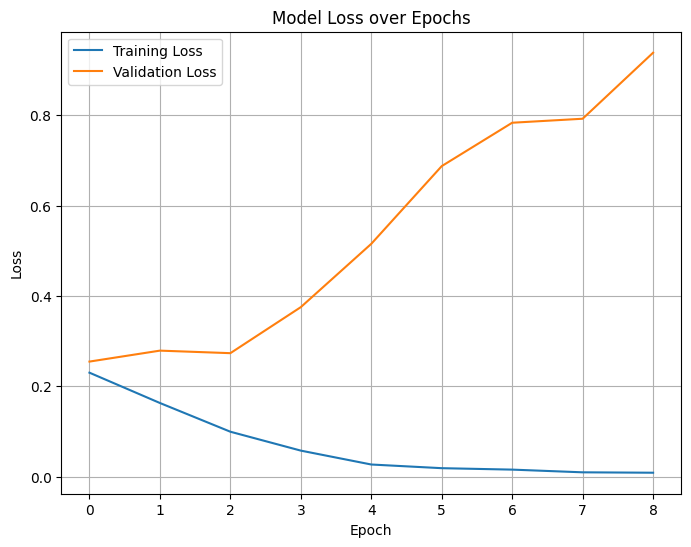

✔ Model saved to /content/drive/MyDrive/colab_content/unet_model_new.keras


In [10]:
def load_model_with_custom_objects(model_path):
    dummy_class_weights = {i: 1.0 for i in range(NUM_CLASSES)}

    custom_objects = {
        'loss': weighted_sparse_categorical_crossentropy(dummy_class_weights),
        'weighted_sparse_categorical_crossentropy': weighted_sparse_categorical_crossentropy
    }

    return tf.keras.models.load_model(model_path, custom_objects=custom_objects)

class DiceScoreCallback(Callback):
    def __init__(self, val_ds, class_names, patience=3):
        super().__init__()
        self.val_ds           = val_ds
        self.class_names      = class_names
        self.patience         = patience
        self.best_dice        = -np.inf
        self.no_improve_count = 0

    def on_epoch_end(self, epoch, logs=None):
        y_true_list, y_pred_list = [], []
        for images, masks in self.val_ds:
            preds     = self.model.predict(images, verbose=0)
            pred_lbls = tf.argmax(preds, axis=-1).numpy().flatten()
            y_pred_list.append(pred_lbls)
            y_true_list.append(masks.numpy().flatten())

        y_true   = np.concatenate(y_true_list)
        y_pred   = np.concatenate(y_pred_list)
        dice_vals = []
        for cls_idx in self.class_names:
            tp   = np.sum((y_true == cls_idx) & (y_pred == cls_idx))
            fp   = np.sum((y_true != cls_idx) & (y_pred == cls_idx))
            fn   = np.sum((y_true == cls_idx) & (y_pred != cls_idx))
            dice = (2 * tp) / (2 * tp + fp + fn + 1e-6)
            dice_vals.append(dice)

        avg_dice = np.mean(dice_vals)
        if logs is not None:
            logs['test_dice'] = avg_dice

        print(f"\nEpoch {epoch+1}: avg dice = {avg_dice:.4f}")

        if avg_dice > self.best_dice + 1e-6:
            self.best_dice        = avg_dice
            self.no_improve_count = 0
        else:
            self.no_improve_count += 1
            print(f"  → no improvement count: "
                  f"{self.no_improve_count}/{self.patience}")

        if self.no_improve_count >= self.patience:
            print(f"Stopping training: no dice improvement "
                  f"in {self.patience} epochs.")
            self.model.stop_training = True


def plot_loss(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

if TRAIN_MODE:
    model = build_unet(input_shape=(*IMG_SIZE, 3), num_classes=NUM_CLASSES)

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)

    model.compile(
        optimizer=optimizer,
        loss=weighted_sparse_categorical_crossentropy(class_weights),
        metrics=['accuracy']
    )

    train_steps = len(train_fo)
    val_steps   = len(val_fo)

    dice_cb = DiceScoreCallback(test_ds, CLASS_NAMES, patience=3)

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )

    history = model.fit(
        train_ds,
        validation_data   = val_ds,
        epochs            = EPOCHS,
        steps_per_epoch   = train_steps,
        validation_steps  = val_steps,
        callbacks         = [dice_cb, reduce_lr],
    )

    plot_loss(history)

    model.save(MODEL_PATH)
    print(f"✔ Model saved to {MODEL_PATH}")

else:
    model = load_model_with_custom_objects(MODEL_PATH)
    print(f"✔ Loaded model from {MODEL_PATH} for inference")

# Evaluation

In [ ]:
y_true_list, y_pred_list = [], []
for images, masks in test_ds:
    preds = model.predict(images, verbose=0)
    pred_labels = tf.argmax(preds, axis=-1).numpy()
    y_true_list.append(masks.numpy().flatten())
    y_pred_list.append(pred_labels.flatten())

y_true = np.concatenate(y_true_list)
y_pred = np.concatenate(y_pred_list)

acc         = accuracy_score(y_true, y_pred)
prec_macro  = precision_score(y_true, y_pred, average='macro', zero_division=0)
rec_macro   = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1_macro    = f1_score(y_true, y_pred, average='macro', zero_division=0)

micro_f1 = f1_score(y_true, y_pred, average='micro', zero_division=0)

dice_scores = {}
for i, cls_name in CLASS_NAMES.items():
    tp = np.sum((y_true==i)&(y_pred==i))
    fp = np.sum((y_true!=i)&(y_pred==i))
    fn = np.sum((y_true==i)&(y_pred!=i))
    dice = (2*tp) / (2*tp + fp + fn + 1e-6)
    dice_scores[cls_name] = dice

print(f"Test Accuracy:           {acc:.4f}")
print(f"Precision (macro):       {prec_macro:.4f}")
print(f"Recall (macro):          {rec_macro:.4f}")
print(f"F1 Score (macro):        {f1_macro:.4f}")
print(f"F1 Score (micro):        {micro_f1:.4f}")
for cls, d in dice_scores.items():
    print(f"Dice coefficient ({cls}): {d:.4f}")

Test Accuracy:           0.8618
Precision (macro):       0.6336
Recall (macro):          0.5335
F1 Score (macro):        0.5719
F1 Score (micro):        0.8618
Dice coefficient (bg): 0.9233
Dice coefficient (airplane): 0.5640
Dice coefficient (train): 0.5439
Dice coefficient (boat): 0.2566


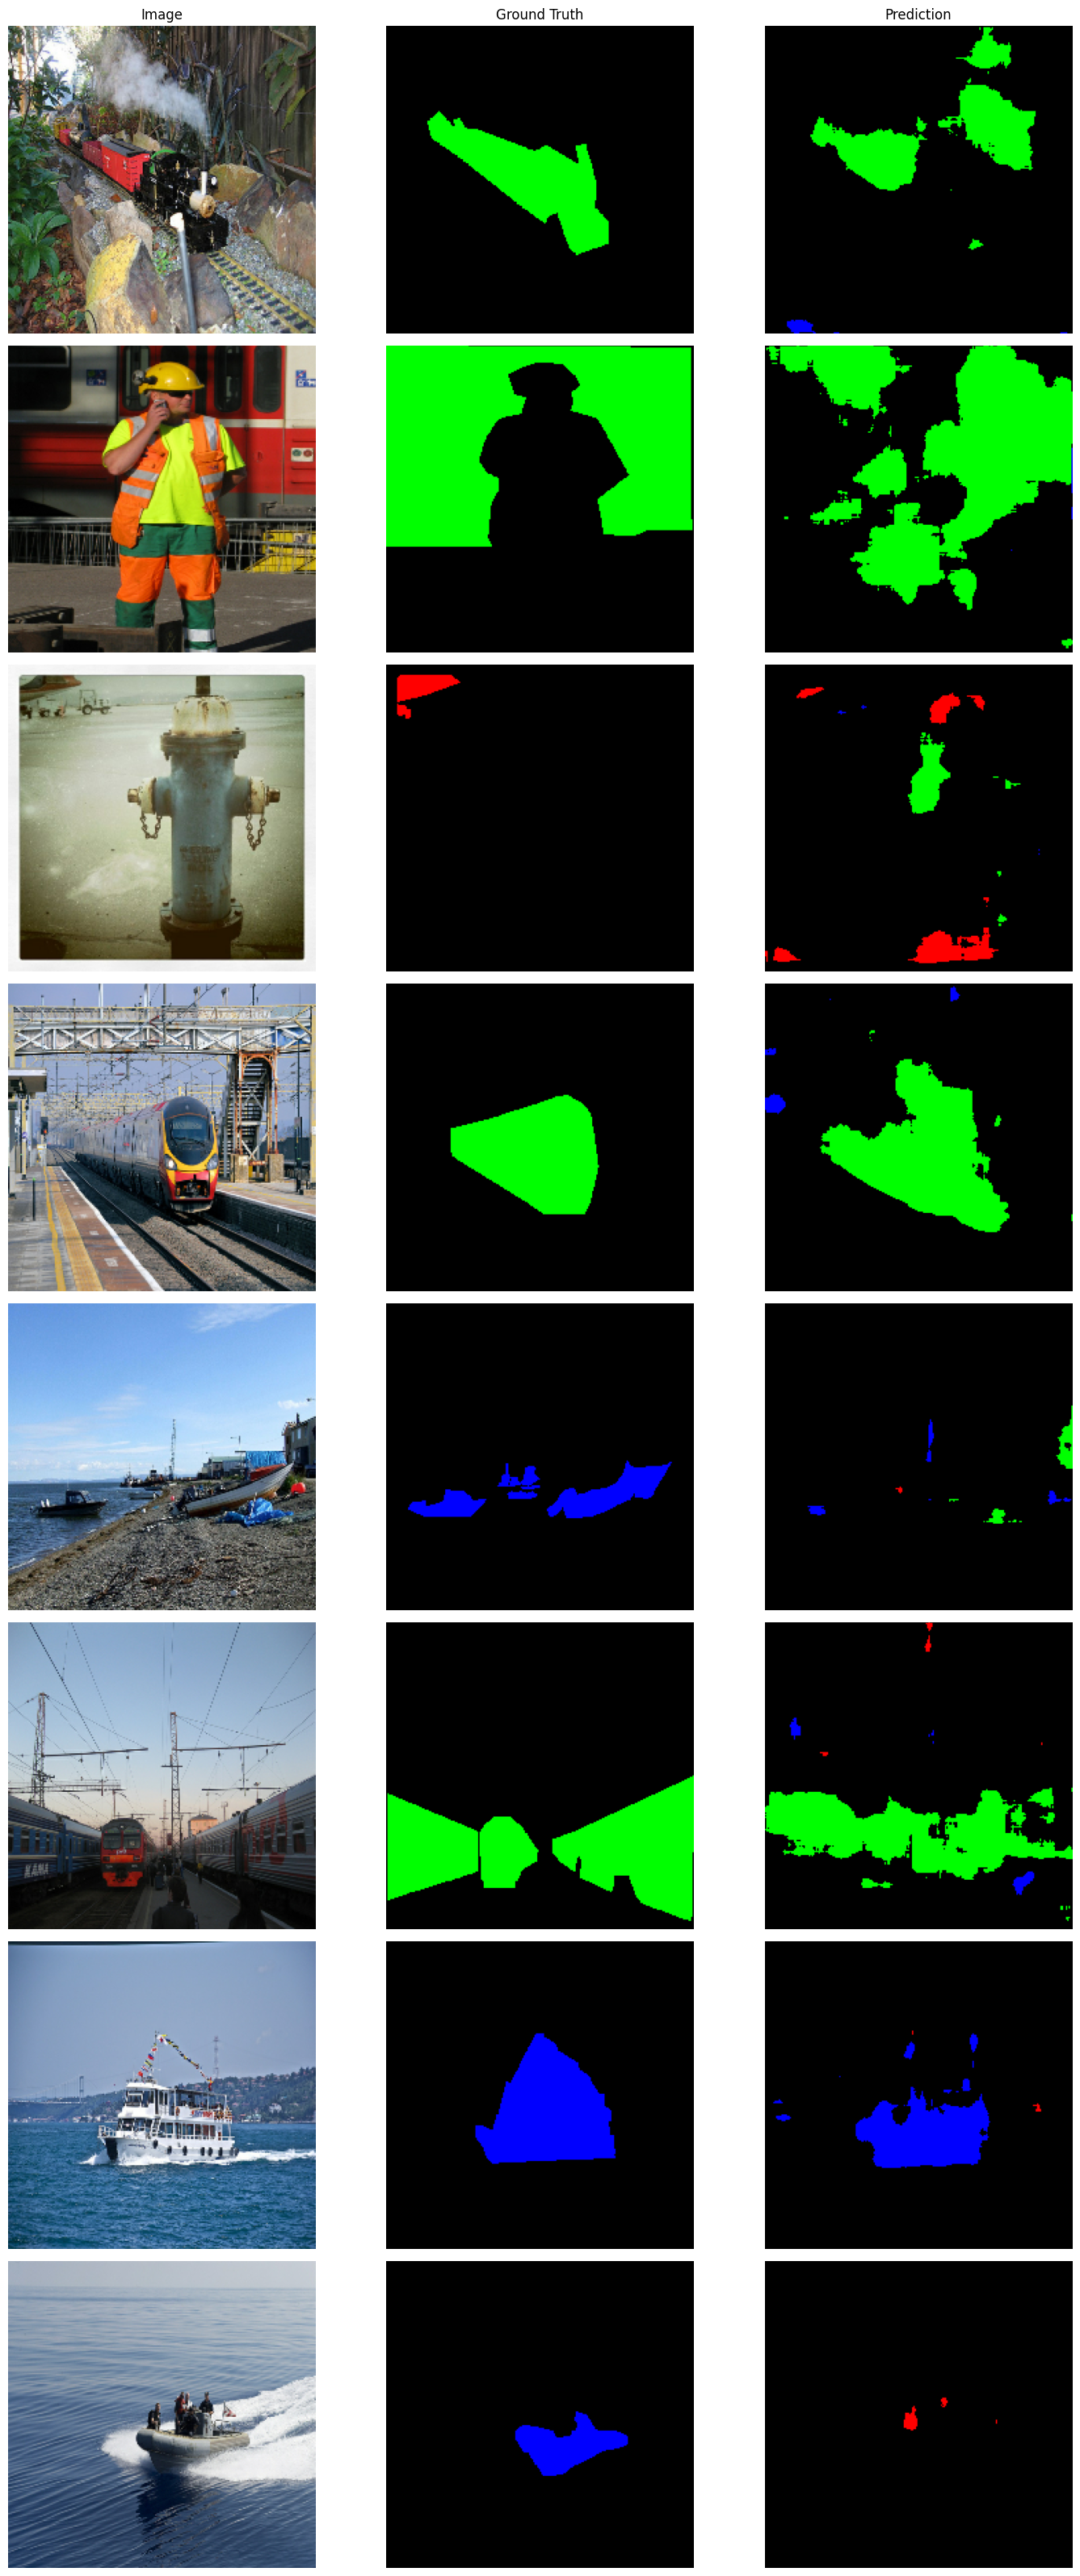

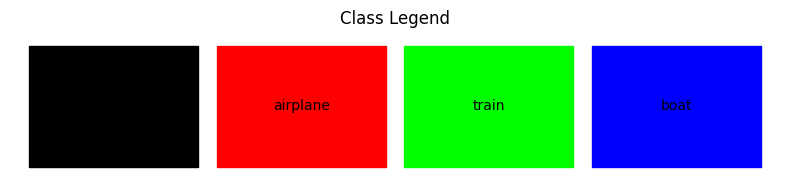

In [ ]:
def visualize_samples(model, dataset, num_samples=8):
    colors = [
        [0, 0, 0],
        [255, 0, 0],
        [0, 255, 0],
        [0, 0, 255],
    ]
    colormap = np.array(colors, dtype=np.uint8)

    samples = []
    for image_batch, mask_batch in dataset.unbatch().take(num_samples):
        pred_mask = model.predict(tf.expand_dims(image_batch, 0), verbose=0)
        pred_mask = tf.argmax(pred_mask, axis=-1)[0].numpy()

        samples.append((
            image_batch.numpy(),
            mask_batch.numpy(),
            pred_mask
        ))

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples * 4))

    axes[0, 0].set_title('Image')
    axes[0, 1].set_title('Ground Truth')
    axes[0, 2].set_title('Prediction')

    for i, (image, true_mask, pred_mask) in enumerate(samples):
        axes[i, 0].imshow(image)
        axes[i, 0].axis('off')

        true_mask_colored = colormap[true_mask]
        axes[i, 1].imshow(true_mask_colored)
        axes[i, 1].axis('off')

        pred_mask_colored = colormap[pred_mask]
        axes[i, 2].imshow(pred_mask_colored)
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

    legend_fig, legend_ax = plt.subplots(figsize=(8, 2))
    legend_ax.set_title('Class Legend')
    for i, (class_name, color) in enumerate(zip(CLASS_NAMES.values(), colors)):
        legend_ax.add_patch(plt.Rectangle((i, 0), 0.9, 0.9, color=[c/255 for c in color]))
        legend_ax.text(i + 0.45, 0.45, class_name, ha='center', va='center')
    legend_ax.set_xlim(-0.1, len(CLASS_NAMES))
    legend_ax.set_ylim(-0.1, 1)
    legend_ax.axis('off')
    plt.tight_layout()
    plt.show()

visualize_samples(model, test_ds, num_samples=8)

# API

https://cdn.prgloo.com/media/f4616b574aeb4ce49d89d85efb29ed6a.jpg

https://www.timeforkids.com/wp-content/uploads/2020/02/feature-cover_-train-k1.jpg

https://www.nationalgeographic.com/content/dam/expeditions/landing-pages/Rail/hero-rail-asia.jpg

https://upload.wikimedia.org/wikipedia/commons/3/36/United_Airlines_Boeing_777-200_Meulemans.jpg

https://www.rosenaviation.com/wp-content/uploads/2024/03/failed-airplane-engine-Rosen-Aviation-scaled.jpeg

https://upload.wikimedia.org/wikipedia/commons/thumb/3/39/Chubasco_photo_D_Ramey_Logan.jpg/1200px-Chubasco_photo_D_Ramey_Logan.jpg

https://www.classicboat.co.uk/wp-content/uploads/Main-Photo-scaled.jpg

In [12]:
app = Flask(__name__)
CORS(app)

CLASS_COLORS = [
    (0, 0, 0, 0),       # transparent, class 0
    (255, 0, 0, 255),   # red, class 1
    (0, 255, 0, 255),   # green, class 2
    (0, 0, 255, 255),   # blue, class 3
]

@app.route('/test', methods=['GET'])
def test_endpoint():
    return jsonify({"message": "Test endpoint working!"}), 200

def load_image_from_request(req):
    if 'file' in req.files:
        img = Image.open(req.files['file']).convert('RGB')
        return img.resize(IMG_SIZE)
    data = req.get_json(force=True, silent=True) or {}
    if 'url' in data:
        resp = requests.get(data['url'])
        img = Image.open(BytesIO(resp.content)).convert('RGB')
        return img.resize(IMG_SIZE)
    raise ValueError("Provide an upload as form-data field 'file' or JSON with 'url'.")

@app.route('/predict', methods=['POST'])
def predict():
    try:
        img = load_image_from_request(request)
    except Exception as e:
        return jsonify({'error': str(e)}), 400

    x     = np.expand_dims(np.array(img) / 255.0, 0)
    preds = model.predict(x)[0]

    zip_buf = BytesIO()
    with zipfile.ZipFile(zip_buf, 'w') as zf:
        orig_buf = BytesIO()
        img.save(orig_buf, format='PNG')
        zf.writestr('original_image.png', orig_buf.getvalue())

        for i, color in enumerate(CLASS_COLORS):
            mask = (preds[..., i] > 0.5).astype(np.uint8) * 255
            mask_img      = Image.fromarray(mask).resize(img.size).convert('L')
            transparent_bg = Image.new('RGBA', img.size, (0, 0, 0, 0))
            overlay        = Image.new('RGBA', img.size, color)
            colored_mask   = Image.composite(overlay, transparent_bg, mask_img)

            buf = BytesIO()
            colored_mask.save(buf, format='PNG')
            classname = CLASS_NAMES[i]
            zf.writestr(f'class_{i}_{classname}_mask.png', buf.getvalue())

    zip_buf.seek(0)
    return send_file(
        zip_buf,
        mimetype='application/zip',
        as_attachment=True,
        download_name='masks.zip'
    )

if __name__ == "__main__":
    ngrok.set_auth_token(NGROK_AUTH_TOKEN)
    public_url = ngrok.connect(5000)
    print("Public URL:", public_url)
    app.run(host="0.0.0.0", port=5000)

Public URL: NgrokTunnel: "https://d7b1-91-233-178-96.ngrok-free.app" -> "http://localhost:5000"
 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://91.233.178.96:5000
Press CTRL+C to quit
127.0.0.1 - - [29/Apr/2025 22:09:42] "OPTIONS /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


127.0.0.1 - - [29/Apr/2025 22:09:43] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [29/Apr/2025 22:09:52] "OPTIONS /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


127.0.0.1 - - [29/Apr/2025 22:09:52] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [29/Apr/2025 22:09:58] "OPTIONS /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


127.0.0.1 - - [29/Apr/2025 22:09:59] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [29/Apr/2025 22:10:09] "OPTIONS /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


127.0.0.1 - - [29/Apr/2025 22:10:10] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [29/Apr/2025 22:11:10] "OPTIONS /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


127.0.0.1 - - [29/Apr/2025 22:11:11] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [29/Apr/2025 22:11:53] "OPTIONS /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


127.0.0.1 - - [29/Apr/2025 22:11:53] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [29/Apr/2025 22:12:16] "OPTIONS /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


127.0.0.1 - - [29/Apr/2025 22:12:16] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [29/Apr/2025 22:12:32] "OPTIONS /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


127.0.0.1 - - [29/Apr/2025 22:12:32] "POST /predict HTTP/1.1" 200 -
